Evidential Deep Learning to Quantify Classification Uncertainty
- aimed at detecting out-of-distribution queries and adversarial samples
- penalizes incorrect evidence on errors and out-of-distribution examples through loss function
    - evidence is a measure of the amount of support
collected from data in favor of a sample to be classified into a certain class
    - tries to shrink the total evidence (relu activation) to zero if the sample cannot be correctly classified 
    - uses Kullback–Leibler divergence (KL) loss to force the model to be uncertain especially when its prediction is incorrect through mean squared error, log likelihood, or digamma
- recognizes when the model is likely to fail

There are two axes of NN uncertainty that can be modeled: 
- (1) uncertainty in the data, called aleatoric uncertainty, and 
- (2) uncertainty in the prediction, called epistemic uncertainty.

This is a computationally efficient alternative to model ensembles, Bayesion NNs, and monte carlo dropout, which also gets at model uncertainty

In [6]:
import torch
import PIL
import torch.nn.functional as F
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from cocpit import config as config
import os
from typing import List, Tuple
import pandas as pd

In [33]:
""" functions for uncertainty calculations """
def model_logit_output(img: PIL.Image) -> torch.Tensor:
    """run model on image and output logit"""
    trans = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
           ),])
    img_tensor = trans(img)
    img_tensor.unsqueeze_(0)
    img_variable = Variable(img_tensor)
    return model(img_variable)

def calc_uncertainty(model: torch.nn.parallel.DataParallel, output: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """calculate max probability prediction, class probability, and uncertainty"""
    softmax = F.softmax(output, dim=1)
    evidence = F.relu(output)
    alpha = evidence + 1
    # uncertainty calculated as # of classes/total evidence summed across classes + 1
    uncertainty = len(config.CLASS_NAMES) / torch.sum(alpha, dim=1, keepdim=True)
    _, pred = torch.max(output, 1)
    prob = alpha / torch.sum(alpha, dim=1, keepdim=True)
    output = output.flatten()
    prob = softmax.flatten()
    pred = pred.flatten()
    return (pred, prob, uncertainty)

def uncertainty_examples(model: torch.nn.parallel.DataParallel, img_paths: List[str]) -> None:
    """loop through a sample of images, make predictions, and output uncertainty"""
    for img_path in img_paths:
        img = Image.open(img_path)
        output = model_logit_output(img)
        pred, prob, uncertainty = calc_uncertainty(model, output)
        plot_uncertainty(img, pred, prob, uncertainty)

def plot_uncertainty(img: PIL.Image, preds: torch.Tensor, prob: torch.Tensor, uncertainty: torch.Tensor, fontsize: int=16) -> None:
    """plot image above with bar chart below of probability and uncertainty value in title"""
    labels = np.arange(len(config.CLASS_NAMES))
    fig, axs = plt.subplots(2, 1, figsize=(6, 12), gridspec_kw={"height_ratios": [3, 1]})

    plt.title(f"Classified as: {config.CLASS_NAMES[preds[0]]}, Uncertainty: {np.round(uncertainty.item(), 3)}", fontsize=fontsize)
    
    axs[0].imshow(img, cmap="gray")
    axs[0].axis("off")

    axs[1].bar(labels, prob.cpu().detach().numpy(), width=0.5)
    plt.xticks(np.arange(len(config.CLASS_NAMES)), config.CLASS_NAMES, rotation='vertical', fontsize=fontsize)

    axs[1].set_ylim([0, 1])
    axs[1].set_xticklabels(config.CLASS_NAMES, fontsize=fontsize)

    axs[1].set_xlabel("Classes", fontsize=fontsize+2)
    axs[1].set_ylabel("Softmax Probability", fontsize=fontsize+2)

    fig.tight_layout()

    #plt.savefig("/ai2es/plots/{}".format(os.path.basename(img_path)))

def uncertainty_acc_hist(grouped_df: pd.DataFrame) -> None:
    """histogram of accuracy binned by uncertainty"""
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    grouped_df['acc'].plot(kind='bar', ax=ax, color='k')
    plt.xlabel('Uncertainty Range', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    xlocs, xlabs = plt.xticks()
    plt.ylim(0.0,1.10)
    plt.ylabel('Mean Accuracy [%]', fontsize=18)
    for index, (c, acc) in enumerate(zip(grouped_df['count'], grouped_df['acc'])):
        shift=0.2 if c < 100 else 0.3
        plt.text(xlocs[index]-shift, acc+0.02, f'{c}', fontsize=16)
    plt.savefig(f'{config.BASE_DIR}/plots/uncertainty_vs_acc_hist.png')

<class 'torch.nn.parallel.data_parallel.DataParallel'>
<class 'torch.nn.parallel.data_parallel.DataParallel'>
<class 'torch.nn.parallel.data_parallel.DataParallel'>
<class 'torch.nn.parallel.data_parallel.DataParallel'>
<class 'torch.nn.parallel.data_parallel.DataParallel'>
<class 'torch.nn.parallel.data_parallel.DataParallel'>
<class 'torch.nn.parallel.data_parallel.DataParallel'>
<class 'torch.nn.parallel.data_parallel.DataParallel'>


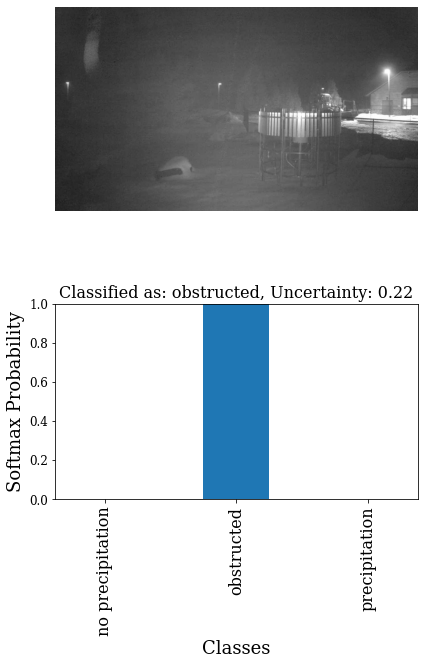

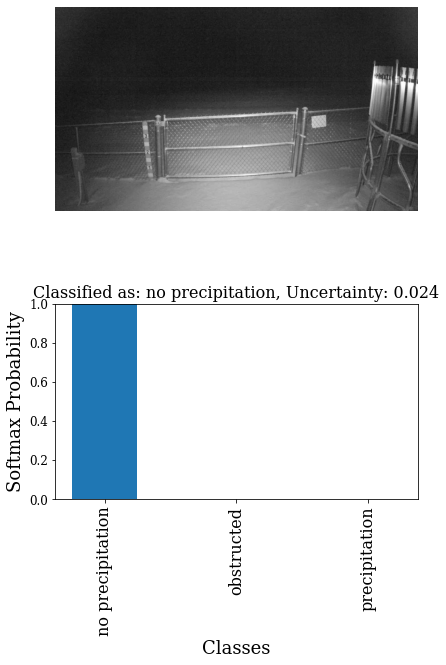

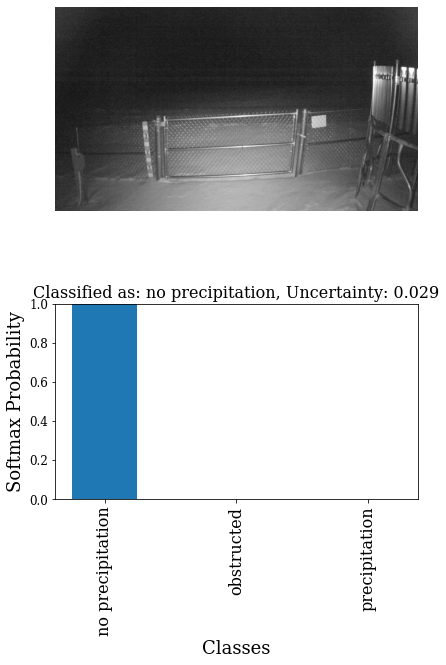

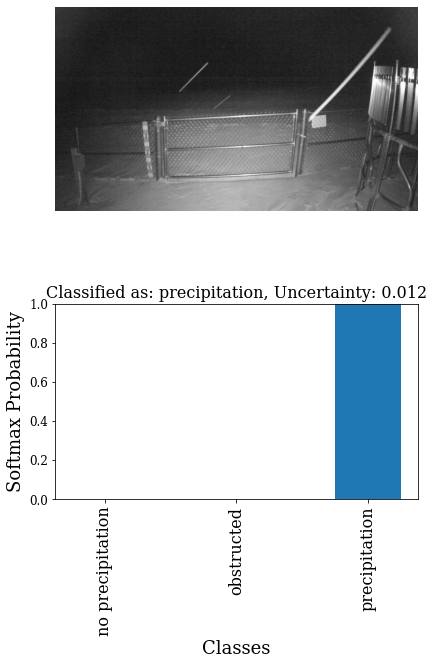

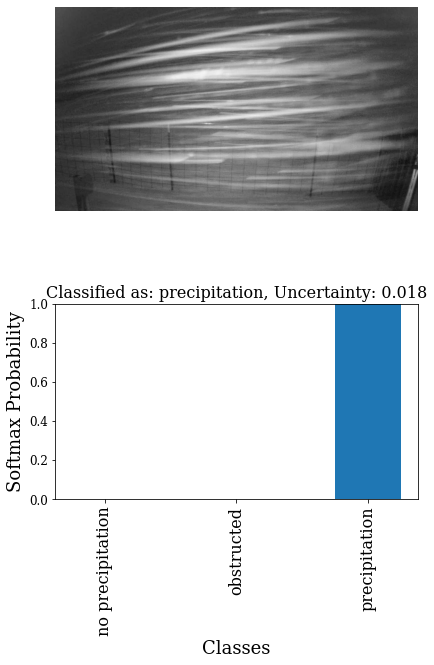

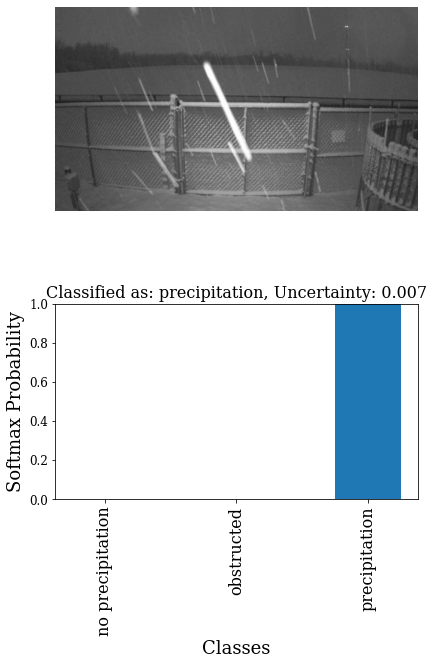

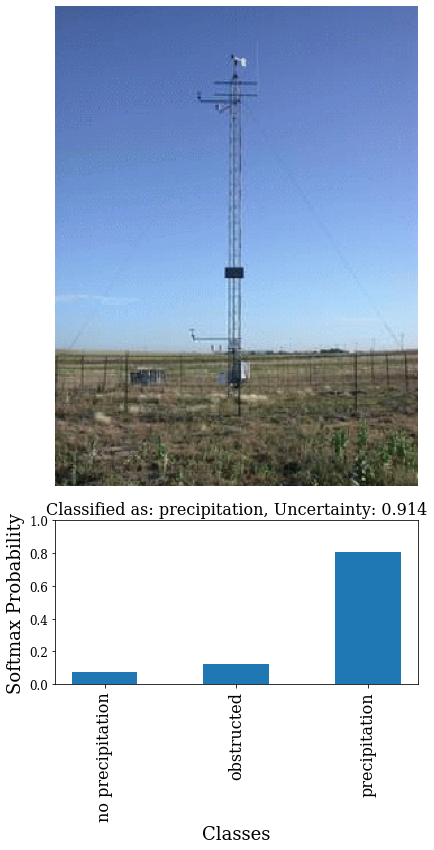

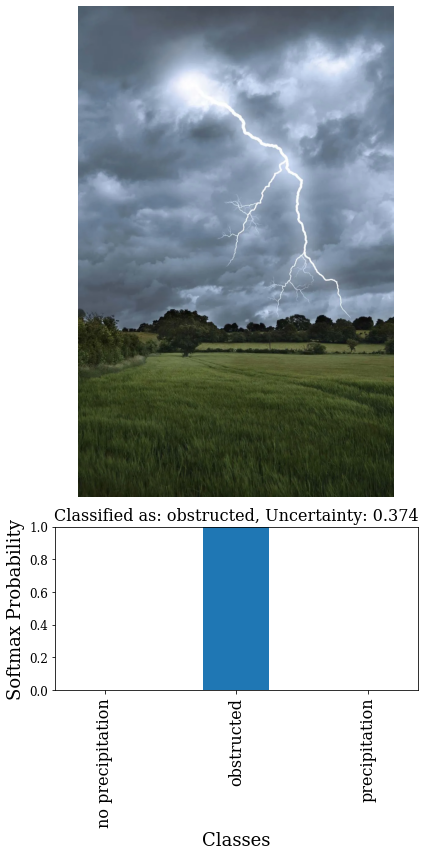

In [ ]:
"""test uncertainty calculation on some hand chosen examples in and out of distribution norms"""
# sourcery skip: avoid-global-variables
model = torch.load('/ai2es/saved_models/v0.0.0/e[20]_bs[64]_k0_1model(s)_evidential.pt')
img_paths = ['/ai2es/codebook_dataset/combined_extra/obstructed/20170103T223007_NHUD.jpg',
                '/ai2es/codebook_dataset/combined_extra/no_precip/20170101T080002_ANDE.jpg',
                '/ai2es/codebook_dataset/combined_extra/no_precip/20170101T112501_ANDE.jpg',
                '/ai2es/codebook_dataset/combined_extra/precip/20170101T030002_ANDE.jpg',
                '/ai2es/codebook_dataset/combined_extra/precip/20220225T112038_WEST.jpg',
                '/ai2es/codebook_dataset/combined_extra/precip/20220312T010027_BUFF.jpg',
                '/ai2es/notebooks/Oklahoma-Mesonet.png',
                '/ai2es/notebooks/thunderstorm-and-lightning.png'
                ]
uncertainty_examples(model, img_paths)

In [21]:
"""Find distribution of evidential uncertainties and softmax probabilitie on validation dataloader"""
# sourcery skip: avoid-global-variables

model = torch.load('/ai2es/saved_models/v0.0.0/e[20]_bs[64]_k0_1model(s)_evidential.pt').to(config.DEVICE)
val_loader = torch.load('/ai2es/saved_val_loaders/v0.0.0/e[20]_val_loader20_bs[64]_k0_1model(s)_evidential.pt')
correct = 0
preds, labels, probs, uncertainties, paths = [], [], [], [], []
with torch.no_grad():
    for ((img, label, path), _) in val_loader:
        img = Image.open(path)
        output = model_logit_output(img)
        pred, prob, uncertainty = calc_uncertainty(model, output)
        preds.append(pred.item())
        labels.append(label)
        probs.append(prob.cpu().numpy())
        uncertainties.append(uncertainty.item())
        paths.append(path)
        #correct += (pred[0] == label).float().sum()
        #total = i
        # if uncertainty > 0.3 and prob[pred[0]] > 0.6:
        #     plot_uncertainty(img, pred, prob, uncertainty)


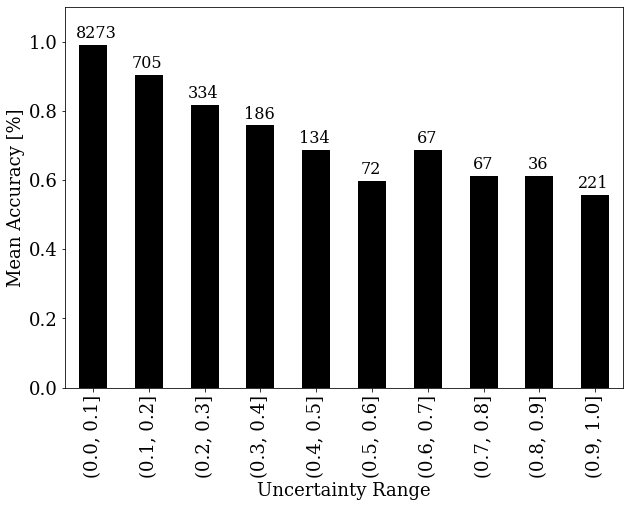

In [36]:
""" group by uncertainty """
# sourcery skip: avoid-global-variables
def grouped_acc_df(group: pd.DataFrame) -> pd.Series:
    """bin df by uncertainty"""
    return pd.Series({'preds': group['preds'],
                   'labels': group['labels'], 
                   'probs': group['probs'],
                   'uncertainties': group['uncertainties'],
                   'paths': group['paths'],
                   'acc': (group['preds'] == group['labels']).mean(), 
                   'count': len(group)})

df = pd.DataFrame(list(zip(preds, labels, probs, uncertainties, paths)), columns = ['preds', 'labels', 'probs', 'uncertainties', 'paths'])
bins = np.linspace(0.0,1.0,11)
df['binned'] = pd.cut(df['uncertainties'], bins)
grouped_df = df.groupby('binned').apply(grouped_acc_df)
uncertainty_acc_hist(grouped_df)